In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numpy.linalg import matrix_power
import scipy
import copy

We consider the cost function $\sum_i tan^2(x_i/c) + \lambda \|u\|^2$

In [2]:
#corrected
#continuous system
# theta_1, theta_1',x_1,x_1', theta_2,theta_2', x_2,x_2'
g=9.81 #gravity
k_sp=1 #spring constante
d=3   #length of relaxed spring
l=1    #length

A=np.array([[0,1,0,0,       0,0,0,0],
            [g/l,0,k_sp/l,0,    0,0,-k_sp/l,0],
            [0,0,0,1,       0,0,0,0],
            [0,0,-k_sp,0,      0,0,k_sp,0],
            [0,0,0,0,       0,1,0,0],
            [0,0,-k_sp/l,0,       g/l,0,k_sp/l,0],
            [0,0,0,0,       0,0,0,1],
            [0,0,k_sp,0,       0,0,-k_sp,0]])
B=np.array([[0,0],
           [-1/l,0],
           [0,0],
           [1,0],
           [0,0],
           [0,-1/l],
           [0,0],
           [0,1]])


nx=8 #dimension of state
nu=2 #dimension of control (in total)
Nu=2 #amount of players
sampling_rate=0.1 

In [3]:
x_ast=np.array([0.0,0.0,0,0.0, 0.0,0.0,d,0.0])
N=5

In [4]:
#discretize system via RK4
steps = 1
dt = sampling_rate/steps

C= -A@x_ast

A_k1 = A
B_k1 = B
C_k1= C
            
A_k2 = A + A@A_k1*(dt/2)
B_k2 = A@B_k1*(dt/2) + B
C_k2=A@C_k1*(dt/2)+C
            
A_k3 = A + A @ A_k2*(dt/2)
B_k3 = A@B_k2*(dt/2) + B
C_k3=A@C_k2*(dt/2)+C
            
A_k4 = A + A @ A_k3 * dt
B_k4 = A@B_k3*dt + B
C_k4=A@C_k3*(dt)+C
            
A_rk4 = (A_k1 + A_k2*2 + A_k3*2 + A_k4)*(dt/6)
B_rk4 = (B_k1 + B_k2*2 + B_k3*2 + B_k4)*(dt/6)
C_rk4 = (C_k1 + C_k2*2 + C_k3*2 + C_k4)*(dt/6)


A_cont=A
B_cont=B
C_cont=C
A = np.eye(nx)   
B= np.zeros((nx,nu))
C=np.zeros(C.shape)
for i in range(steps):
    C = C+ A@C_rk4
    B = B+ A@B_rk4
    A = A+ A@A_rk4             

In [5]:
#parameters
alpha=0.1  #alpha-pertubation
beta=0.    #regularization of Nikaido-Isoda
gamma=0.5    #penealty control
b=100    #bounds
c=15   #scaling parameter penality state

In [6]:
c**2

225

In [7]:
P=scipy.linalg.solve_discrete_are(A, B, (1/c**2)*np.eye(nx), gamma*np.eye(nu), e=None, s=None, balanced=True)
P/=1
def F_end(x):
    return np.dot(x-x_ast,P@(x-x_ast))

In [8]:
from scipy.optimize import Bounds
b=100
BT=B.transpose()
M=np.linalg.inv(gamma*np.eye(nu)+BT@P@B)@BT@P@A
bounds = Bounds(N*nu*[-b], N*nu*[b])
delta=np.sqrt(nu)*b/np.linalg.norm(M) #bound for X_0 ball

In [9]:
#compute smallest eigenvalue of P
eigenvalues, eigenvectors=np.linalg.eig(P)
lam_P_min=max(eigenvalues)

In [10]:
#parameter for X_0={x : V_inf(x) < =V_bound}
#V_bound= bx**2*np.linalg.norm(P)
V_bound= (delta**2)* lam_P_min

In [11]:
V_bound

12004.041446990432

In [12]:
nx_p=nx//Nu
nu_p=nu//Nu
def ell(x,u,i):
    res=0
    for j in range(i*nx_p,i*nx_p+nx_p):
        res+=np.tan((x[j]-x_ast[j])/c)**2
    res+=gamma*0.5*np.dot(u[i*nu_p:i*nu_p+nu_p],u[i*nu_p:i*nu_p+nu_p])
    return res

In [13]:
def inner_objective(u,x_iv,v):
    u=u.reshape((N,nu))
    v=v.reshape((N,nu))
   #input u in form (N,nu)
    su=0
    for i in range(Nu):
        x=x_iv
        contrl=copy.deepcopy(u)
        contrl[:,i*nu_p:nu_p+i*nu_p]=v[:,i*nu_p:nu_p+i*nu_p] 
        for k in range(N):
            su+= ell(x,contrl[k],i)
            x=A@x+B@contrl[k]+C     
    diff=u-v
    su+=beta*0.5*np.dot(diff.flatten(),diff.flatten())              
    return su

In [14]:
def tan2_derivative(x):
    return (2/c)*np.sin(x/c)/(np.cos(x/c)**3)

In [15]:
K=[matrix_power(A,k)@B for k in range(N)]
def inner_objective_jac(u,x_iv,v):
    u=u.reshape((N,nu))
    v=v.reshape((N,nu))
    jac=np.zeros((N,nu))
    for i in range(Nu):
        x=x_iv
        control=copy.deepcopy(u)
        control[:,i*nu_p:nu_p+i*nu_p]=v[:,i*nu_p:nu_p+i*nu_p]
        for k in range(N):
            # diff refers to the outer derivative
            #diff=x[i*nx_p:i*nx_p+nx_p]-x_ast[i*nx_p:i*nx_p+nx_p]
            diff=tan2_derivative(x[i*nx_p:i*nx_p+nx_p]-x_ast[i*nx_p:i*nx_p+nx_p])
            for n in range(0,k):
                tmp=diff@K[k-n-1][i*nx_p:i*nx_p+nx_p,i*nu_p:nu_p+i*nu_p]
                jac[n,i*nu_p:nu_p+i*nu_p]+=tmp.flatten()
            if k <N:
                x=A@x+B@control[k]+C     
        jac[0:N,i*nu_p:nu_p+i*nu_p]+=gamma*v[0:N,i*nu_p:nu_p+i*nu_p]
    jac+=beta*(v-u)    
    return jac.reshape(-1)

In [16]:
def g(x_iv,u):
    obj= lambda v: inner_objective(u,x_iv,v)
    jac= lambda v: inner_objective_jac(u,x_iv,v)
    v_0=np.zeros(u.shape).flatten()
    
    solution=minimize(obj,v_0, method="L-BFGS-B", jac=jac,bounds=bounds)
    if not solution.success:
        print("inner",solution.message)
    return solution

In [17]:
def objective(x_iv,u):
    u=u.reshape((N,nu)) 
    sec=0
    sec=(1-alpha)*g(x_iv,u).fun
    
    first=0
    x=x_iv
    for k in range(N):
        for i in range(Nu):
            first+=ell(x,u[k],i)       
        x=A@x+B@u[k]+C 
    return first-sec +F_end(x)

In [18]:
K=[matrix_power(A,k)@B for k in range(N)]
def objective_jac(x_iv,u):  #only with respect to u
    u=u.reshape((N,nu))
    jac=np.zeros((N,nu))

    #part dependent on u only
    contrl=copy.deepcopy(u)
    x=copy.deepcopy(x_iv)
    for k in range(N):
        diff=(tan2_derivative(x-x_ast)).transpose()
        for n in range(0,k):
            jac[n,:]+=diff@K[k-n-1]
        if k <N:
            x=A@x+B@contrl[k]+C 
    jac+=gamma*u
    for n in range(N):
        jac[n,:]+=2*(x-x_ast).transpose()@P@K[N-n-1] 
    #second part
    v=g(x_iv,u).x
    v=v.reshape((N,nu))
    for i in range(Nu):
        x=x_iv
        contrl=copy.deepcopy(u)
        contrl[:,i*nu_p:nu_p+i*nu_p]=v[:,i*nu_p:nu_p+i*nu_p]
        j=1-i
        for n in range(N):
            diff=tan2_derivative(x[i*nx_p:i*nx_p+nx_p]-x_ast[i*nx_p:i*nx_p+nx_p])
            for k in range(0,n):
                tmp=diff@K[n-k-1][i*nx_p:i*nx_p+nx_p,j*nu_p:nu_p+j*nu_p]
                jac[k,j*nu_p:nu_p+j*nu_p]+=-(1-alpha)*tmp
            if n<N:
                x=A@x+B@contrl[n]+C
    jac+=beta*(v-u)            
    return jac.reshape(-1)

In [19]:
def endcond(u,x_iv):
    u=u.reshape((N,nu))
    x=x_iv
    for k in range(N):
        x=A@x+B@u[k] +C
    return V_bound-F_end(x)

In [20]:
def eq_endcond(u,x_iv):
    u=u.reshape((N,nu))
    x=x_iv
    for k in range(N):
        x=A@x+B@u[k] +C
    return x-x_ast

In [21]:
def upperbound(u):
    return (b*np.ones(N*nu)-u)
def lowerbound(u):
    return (u+b*np.ones(N*nu))

In [22]:
maxIter=400
x_ivv=np.asarray([0.6*np.pi,0,0,0,0,0,d,0])

In [23]:
noise=100

In [24]:
x_iv=x_ivv
u_0=np.zeros(N*nu)
u_star=[]
x_star=[]
V=[]
x_end=[]
x_eq_end=[]
x_F=[]
x_Last=[]
x_star.append(x_iv)
for i in range(maxIter):
    if i%10==0:
        print(i)
    obj= lambda u: objective(x_iv,u)
    jac= lambda u: objective_jac(x_iv,u)
    ec= lambda u: endcond(u,x_iv)/V_bound*b
    end_cond={'type': "ineq",'fun': ec}
    eq_end_cond={'type': "ineq",'fun': ec}
    upper={'type': "ineq",'fun': upperbound}
    lower={'type': "ineq",'fun': lowerbound}
    solution=minimize(obj,u_0,method="SLSQP",constraints=[end_cond, upper, lower],jac=jac)
    if not solution.success:
        print(i, solution.message)
    contrl=solution.x
    contrl=contrl.reshape((N,nu))
    x_last=x_iv
    for k in range(N):
        x_last=A@x_last +B@contrl[k]+C
    x_Last.append(endcond(contrl,x_iv)) #should be negative
    x_eq_end.append(eq_endcond(contrl,x_iv))
    x_F.append(F_end(x_last))
    V.append(solution.fun)
    #u_star.append(solution.x[0])
    u_curr=solution.x.reshape((N,nu))[0]
    u_star.append(u_curr)
    x_iv=A@x_iv+B@u_curr+C
  #  x_iv=addnoise_fac(x_iv, noise)
    x_star.append(x_iv)
   # u_0=solution.x

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390


In [25]:
import os
dictname="tan/020"
os.makedirs(dictname)

In [26]:
with open(dictname+"/stats.txt", "w") as file:
    file.write("alpha="+str(alpha))
    file.write("\n")
    file.write("inital value="+str(x_ivv))
    file.write("\n")
    file.write("N="+str(N))
    file.write("\n")
    file.write("noise="+str(noise))
    file.write("\n")
    file.write("U=["+str(-b)+","+str(b)+"]")
    file.write("\n")
    file.write("gamma="+str(gamma))
    file.write("\n")
    file.write("beta="+str(beta))
    file.write("\n")
    file.write("spring="+str(k_sp))
    file.write("\n")
    file.write("rod_length="+str(l))
    file.write("\n")
    file.write("c="+str(c))
    file.write("\n")
    file.write("nu bound in X_0="+str(V_bound))

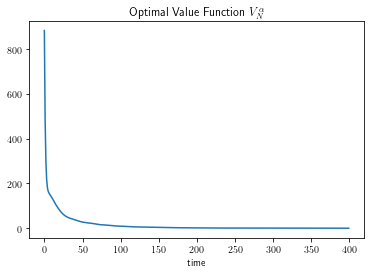

In [34]:
plt.plot(V)
#plt.rc('text', usetex = True)
plt.title(r'Optimal Value Function  $V_N^\alpha$')
plt.xlabel("time")
plt.savefig("./"+dictname+"/optimalvalue.pdf")

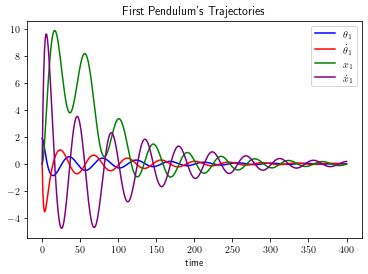

In [28]:
X_star=np.asarray(x_star)
import matplotlib.pyplot as plt
plt.plot(X_star[:,0],"blue", label=r"$\theta_1$")
plt.plot(X_star[:,1],"red", label=r"$\dot{\theta}_1$")
plt.plot(X_star[:,2],"green", label=r"$x_1$")
plt.plot(X_star[:,3],"purple",label=r"$\dot{x}_1$")
plt.legend()
plt.title("First Pendulum's Trajectories")
plt.xlabel("time")
plt.savefig("./"+dictname+"/pendlum1.pdf")

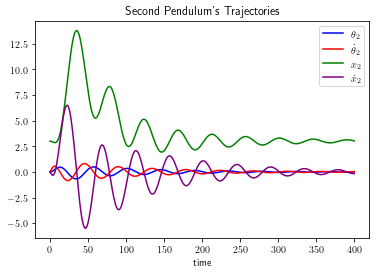

In [29]:
plt.plot(X_star[:,4],"blue", label=r"$\theta_2$")
plt.plot(X_star[:,5],"red", label=r"$\dot{\theta}_2$")
plt.plot(X_star[:,6],"green", label=r"$x_2$")
plt.plot(X_star[:,7],"purple",label=r"$\dot{x}_2$")
plt.legend()
plt.xlabel("time")
plt.title("Second Pendulum's Trajectories")
plt.savefig("./"+dictname+"/pendlum2.pdf")

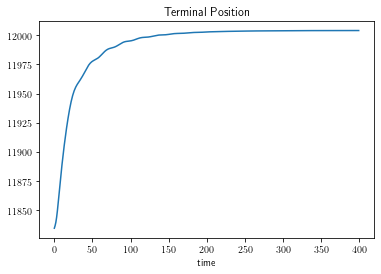

In [30]:
X_Last=[x for x in x_Last]
X_Last=np.asarray(X_Last)
plt.plot(X_Last)
plt.title("Terminal Position")
plt.xlabel("time")
plt.savefig("./"+dictname+"/xLast.pdf")

Text(0.5, 1.0, 'Equilibrium Endpoint Constraint')

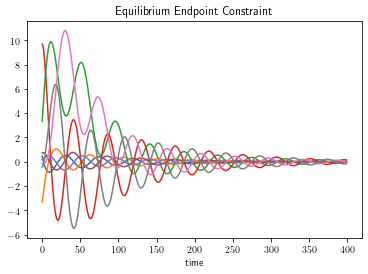

In [31]:
plt.xlabel("time")
plt.plot(x_eq_end)
plt.title("Equilibrium Endpoint Constraint")

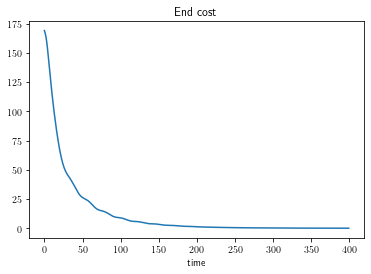

In [32]:
plt.plot(x_F)
plt.title("End cost")
plt.xlabel("time")
plt.savefig("./"+dictname+"/terminalCost.pdf")

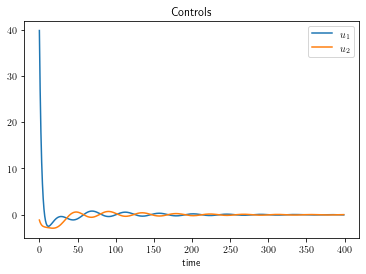

In [33]:
U_star=np.asarray(u_star)
plt.plot(U_star[:,0], label=r"$u_1$")
plt.plot(U_star[:,1],label=r"$u_2$")
plt.legend()
plt.title('Controls')
plt.xlabel("time")
plt.savefig("./"+dictname+"/controls.pdf")

In [36]:
V_bound-F_end(x_ast)

11813.77329254898

In [37]:
x_F[-1]

1.12229763421546e-05